In [1]:
# Cell 1: Install required libraries (run once, or skip if already installed)
# ------------------------------------------------------------------------
# This project uses:
# - torch, transformers: for BERT-based sentence embeddings
# - datasets: to load the IMDb movie-review sentiment dataset
# - scikit-learn, pandas, matplotlib: for preprocessing, classifiers, and plots
# - gradio: for building an interactive GUI around the sentiment system
# Comment out this cell if your environment already has these.

!pip install -q torch torchvision torchaudio transformers scikit-learn pandas matplotlib datasets joblib gradio


In [2]:
# Cell 2: Imports and global configuration
# ----------------------------------------
# This cell imports all the modules we need and defines project-wide settings:
# - DATASET_NAME: which sentiment dataset to use
# - SEED: random seed for reproducibility
# - MODEL_NAME: which BERT checkpoint to use
# - MAX_LEN: max token length for BERT
# - BATCH_SIZE: batch size for embedding computation
# - PCA_COMPONENTS_LIST: list of PCA dimensions to experiment with
# - DEVICE: CPU or GPU (if available)
# - MAX_*_SAMPLES: optional subsampling to keep runtime Colab-friendly

import os
import math
import random
from collections import Counter

import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel

from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

from joblib import dump, load  # for saving/loading PCA models

# ---- Global config ----
FAST_MODE = True   # Set to False when you want the best accuracy and don't mind the extra time

DATASET_NAME = "imdb"
SEED = 42

# PCA dimensions to test (you can adjust these for speed vs. detail)
PCA_COMPONENTS_LIST = [16, 32, 64, 128, 256]

if FAST_MODE:
    MODEL_NAME = "distilbert-base-uncased"   # faster, smaller model than bert-base-uncased
    MAX_LEN = 96                             # shorter sequences => fewer tokens to process
    BATCH_SIZE = 256                          # bigger batches = better throughput on CPU/GPU
    MAX_TRAIN_SAMPLES = 10000                # smaller train set (still plenty for IMDb)
    MAX_VAL_SAMPLES   = 2000
    MAX_TEST_SAMPLES  = 2000
else:
    MODEL_NAME = "bert-base-uncased"
    MAX_LEN = 128
    BATCH_SIZE = 32
    # Set any of these to None to use the full split.
    MAX_TRAIN_SAMPLES = 20000   # from training split (before val split)
    MAX_VAL_SAMPLES   = 5000    # from validation subset
    MAX_TEST_SAMPLES  = 5000    # from test split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
print("FAST_MODE =", FAST_MODE)
print("Dataset:", DATASET_NAME)
print("BERT model:", MODEL_NAME)

Using device: cuda
FAST_MODE = True
Dataset: imdb
BERT model: distilbert-base-uncased


In [3]:
# Cell 3: Reproducibility and batching utilities
# ----------------------------------------------
# This cell defines helper functions:
# - set_seed(): sets seeds for Python, NumPy, and PyTorch
# - batch_iter(): simple batching generator for lists/arrays

def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)


def batch_iter(iterable, batch_size: int):
    """
    Yield chunks of size `batch_size` from `iterable`.
    This is used to process texts and embeddings in batches.
    """
    length = len(iterable)
    for idx in range(0, length, batch_size):
        yield iterable[idx: idx + batch_size]


In [4]:
# Cell 4: Load the IMDb dataset and create train/val/test splits
# --------------------------------------------------------------
# This cell:
# - Loads the IMDb movie-review sentiment dataset via Hugging Face `datasets`
# - Uses the built-in train/test splits
# - Further splits the train set into train/validation
# - Optionally subsamples to keep runtime manageable
# Result:
#   X_train, X_val, X_test: lists of review texts
#   y_train, y_val, y_test: lists of integer labels (0 = negative, 1 = positive)

raw_dataset = load_dataset(DATASET_NAME)

train_dataset = raw_dataset["train"]
test_dataset  = raw_dataset["test"]

print("Original sizes -> Train:", len(train_dataset), "Test:", len(test_dataset))

# Optional sub-sampling for speed
if MAX_TRAIN_SAMPLES is not None and MAX_TRAIN_SAMPLES < len(train_dataset):
    train_dataset = train_dataset.shuffle(seed=SEED).select(range(MAX_TRAIN_SAMPLES))

if MAX_TEST_SAMPLES is not None and MAX_TEST_SAMPLES < len(test_dataset):
    test_dataset = test_dataset.shuffle(seed=SEED).select(range(MAX_TEST_SAMPLES))

print("After optional sub-sampling -> Train:", len(train_dataset), "Test:", len(test_dataset))

# Extract texts and labels
texts_full_train  = [ex["text"] for ex in train_dataset]
labels_full_train = [int(ex["label"]) for ex in train_dataset]

texts_test  = [ex["text"] for ex in test_dataset]
labels_test = [int(ex["label"]) for ex in test_dataset]

# Train/validation split from the training portion
X_train, X_val, y_train, y_val = train_test_split(
    texts_full_train,
    labels_full_train,
    test_size=0.15,
    random_state=SEED,
    stratify=labels_full_train,
)

X_test = texts_test
y_test = labels_test

# Optional additional sub-sampling on validation for speed
if MAX_VAL_SAMPLES is not None and MAX_VAL_SAMPLES < len(X_val):
    X_val, y_val = X_val[:MAX_VAL_SAMPLES], y_val[:MAX_VAL_SAMPLES]

print(f"Final sizes -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Label set:", sorted(set(y_train)))
print("Label mapping (IMDb sentiment): 0 = negative, 1 = positive")


README.md: 0.00B [00:00, ?B/s]

C:\Users\dylan\anaconda3\envs\PrinsMachLearning\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dylan\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Original sizes -> Train: 25000 Test: 25000
After optional sub-sampling -> Train: 10000 Test: 2000
Final sizes -> Train: 8500, Val: 1500, Test: 2000
Label set: [0, 1]
Label mapping (IMDb sentiment): 0 = negative, 1 = positive


In [5]:
# Cell 5: Load BERT tokenizer and model
# -------------------------------------
# This cell:
# - Loads the BERT tokenizer and model from Hugging Face
# - Moves the model to the chosen device (CPU or GPU)
# - Puts the model in eval() mode since we're only doing inference

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

model.to(DEVICE)
model.eval()

print("Loaded BERT model:", MODEL_NAME)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\dylan\anaconda3\envs\PrinsMachLearning\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dylan\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loaded BERT model: distilbert-base-uncased


In [6]:
# Cell 6: Define function to compute mean-pooled BERT embeddings
# --------------------------------------------------------------
# This cell defines `get_bert_embeddings()`:
# - Takes a list of texts (movie reviews)
# - Tokenizes them for BERT
# - Runs them through BERT
# - Applies attention-mask-aware mean pooling across tokens
# Returns:
#   A NumPy array of shape (N, hidden_size) with one vector per text.

def get_bert_embeddings(texts, batch_size: int = BATCH_SIZE, max_len: int = MAX_LEN):
    """
    Compute mean-pooled BERT embeddings for a list of texts.

    Args:
        texts: list of strings (movie reviews)
        batch_size: batch size for inference
        max_len: maximum token length for BERT

    Returns:
        np.ndarray of shape (N, hidden_size)
    """
    all_embeddings = []

    # Turn off gradient tracking for efficiency
    with torch.no_grad():
        for batch_texts in batch_iter(texts, batch_size):
            # Tokenize a batch of texts (pad and truncate to max_len)
            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )

            # Move tokenized batch to the same device as the model
            enc = {k: v.to(DEVICE) for k, v in enc.items()}

            # Forward pass through BERT
            outputs = model(**enc)
            last_hidden = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

            # Build mask for non-padding tokens: shape (batch_size, seq_len, 1)
            mask = enc["attention_mask"].unsqueeze(-1).type(torch.float32)

            # Multiply token embeddings by mask to zero out padding
            masked_hidden = last_hidden * mask

            # Sum across sequence length
            summed = masked_hidden.sum(dim=1)      # (batch_size, hidden_size)

            # Count non-padding tokens per example
            counts = mask.sum(dim=1)               # (batch_size, 1)

            # Compute mean pooling: sum / count
            mean_pooled = summed / counts.clamp(min=1e-9)

            # Move to CPU and convert to NumPy
            all_embeddings.append(mean_pooled.cpu().numpy())

    # Stack all batches into a single array
    return np.vstack(all_embeddings)


# Compute embeddings for train/val/test splits
# NOTE: This may take some time, especially on CPU. For quicker testing,
#       you can further slice X_train/X_val/X_test (e.g., X_train[:5000]) first.
train_emb_full = get_bert_embeddings(X_train)
val_emb_full   = get_bert_embeddings(X_val)
test_emb_full  = get_bert_embeddings(X_test)

print("Train embeddings shape:", train_emb_full.shape)
print("Val embeddings shape:",   val_emb_full.shape)
print("Test embeddings shape:",  test_emb_full.shape)


Train embeddings shape: (8500, 768)
Val embeddings shape: (1500, 768)
Test embeddings shape: (2000, 768)


In [7]:
# Cell 7: Define PCA helper functions
# -----------------------------------
# This cell provides:
# - fit_pca(): trains PCA or IncrementalPCA on the training embeddings
# - compress_embeddings(): applies PCA transform
# - reconstruct_embeddings(): inverts PCA to approximate original embeddings
# These utilities are used to compress and reconstruct BERT embeddings.

def fit_pca(train_embeddings: np.ndarray, n_components: int, incremental: bool = False, batch_size: int = 1024):
    """
    Fit PCA or IncrementalPCA on training embeddings.

    Args:
        train_embeddings: np.ndarray of shape (N, D)
        n_components: target PCA dimension
        incremental: whether to use IncrementalPCA for very large N
        batch_size: batch size for incremental fitting

    Returns:
        Fitted PCA (or IncrementalPCA) object.
    """
    if incremental:
        pca = IncrementalPCA(n_components=n_components)
        for batch in batch_iter(train_embeddings, batch_size):
            pca.partial_fit(batch)
    else:
        pca = PCA(n_components=n_components)
        pca.fit(train_embeddings)
    return pca


def compress_embeddings(embeddings: np.ndarray, pca) -> np.ndarray:
    """
    Apply PCA transform to reduce embedding dimensionality.

    Args:
        embeddings: np.ndarray of shape (N, D)
        pca: fitted PCA object

    Returns:
        np.ndarray of shape (N, n_components)
    """
    return pca.transform(embeddings)


def reconstruct_embeddings(compressed: np.ndarray, pca) -> np.ndarray:
    """
    Reconstruct full-dimensional embeddings from compressed ones.

    Args:
        compressed: np.ndarray of shape (N, n_components)
        pca: fitted PCA object

    Returns:
        np.ndarray of shape (N, original_D)
    """
    return pca.inverse_transform(compressed)


In [8]:
# Cell 8: Train PCA models and generate compressed embeddings
# -----------------------------------------------------------
# This cell:
# - Fits a PCA model for each n_components in PCA_COMPONENTS_LIST
# - Compresses train/val/test full BERT embeddings using each PCA model
# - Optionally saves each PCA model to disk

# Dictionaries to hold PCA models and compressed embeddings for each k
pca_models = {}
compressed_train = {}
compressed_val = {}
compressed_test = {}

for k in PCA_COMPONENTS_LIST:
    print(f"Fitting PCA with n_components={k}...")

    # Fit PCA on full training embeddings
    pca_k = fit_pca(train_emb_full, n_components=k, incremental=False)
    pca_models[k] = pca_k

    # Save PCA model to disk for reuse (optional)
    dump(pca_k, f"pca_k{k}.joblib")

    # Compress train/val/test embeddings
    compressed_train[k] = compress_embeddings(train_emb_full, pca_k)
    compressed_val[k]   = compress_embeddings(val_emb_full,   pca_k)
    compressed_test[k]  = compress_embeddings(test_emb_full,  pca_k)

    print(f"  Train compressed shape for k={k}: {compressed_train[k].shape}")


Fitting PCA with n_components=16...
  Train compressed shape for k=16: (8500, 16)
Fitting PCA with n_components=32...
  Train compressed shape for k=32: (8500, 32)
Fitting PCA with n_components=64...
  Train compressed shape for k=64: (8500, 64)
Fitting PCA with n_components=128...
  Train compressed shape for k=128: (8500, 128)
Fitting PCA with n_components=256...
  Train compressed shape for k=256: (8500, 256)


In [9]:
# Cell 9: Build token-level IDF scores for the minimal deletion baseline
# ---------------------------------------------------------------------
# This cell:
# - Iterates over the training texts
# - Tokenizes each text (without special tokens)
# - Counts how many documents each token appears in (document frequency)
# - Converts DF to IDF scores: higher IDF => rarer token => more "important"
# The resulting idf_scores dict will be used to decide which tokens to keep.

def build_idf_scores(texts, tokenizer, max_len=None):
    """
    Build a token_id -> IDF score dictionary from a list of texts.

    Args:
        texts: list of strings
        tokenizer: Hugging Face tokenizer
        max_len: optional max length for truncation during tokenization

    Returns:
        dict mapping token_id (int) -> IDF score (float)
    """
    df_counts = Counter()
    n_docs = len(texts)

    for text in texts:
        # Tokenize without adding special tokens ([CLS], [SEP], etc.)
        enc = tokenizer(
            text,
            add_special_tokens=False,
            truncation=True,
            max_length=max_len
        )
        token_ids = enc["input_ids"]

        # Unique tokens per document for document frequency
        unique_tokens = set(token_ids)
        for tok_id in unique_tokens:
            df_counts[tok_id] += 1

    # Convert document frequencies to IDF scores
    idf_scores = {}
    for tok_id, df in df_counts.items():
        # Standard IDF with smoothing: log((N+1)/(df+1)) + 1
        idf_scores[tok_id] = math.log((n_docs + 1) / (df + 1)) + 1.0

    return idf_scores


idf_scores = build_idf_scores(X_train, tokenizer, max_len=MAX_LEN)
print("Built IDF scores for", len(idf_scores), "unique tokens.")


Built IDF scores for 18703 unique tokens.


In [10]:
# Cell 10: Define a function to compress a single text via minimal deletion
# ------------------------------------------------------------------------
# This cell:
# - Tokenizes a single text without special tokens
# - Computes an IDF-based importance score per token
# - Keeps the top-k tokens according to a keep_ratio
# - Reconstructs a shorter text from the kept tokens
# The result is a compressed text that we will later embed with BERT.

def compress_text_by_deletion(
    text: str,
    tokenizer,
    idf_scores: dict,
    keep_ratio: float,
    max_len=None
) -> str:
    """
    Compress a single text by keeping only the most "important" tokens
    according to IDF scores.

    Args:
        text: input string (movie review)
        tokenizer: Hugging Face tokenizer
        idf_scores: dict mapping token_id -> IDF
        keep_ratio: fraction of tokens to keep
        max_len: optional max token length during tokenization

    Returns:
        A shorter text string obtained by deleting low-IDF tokens.
    """
    enc = tokenizer(
        text,
        add_special_tokens=False,
        truncation=True,
        max_length=max_len
    )
    token_ids = enc["input_ids"]
    if len(token_ids) == 0:
        return text  # fallback: nothing to compress

    L = len(token_ids)
    target_len = max(1, int(L * keep_ratio))

    # Score each token by its IDF value (default 0.0 if not in the dict)
    scored_tokens = [(tok_id, idf_scores.get(tok_id, 0.0)) for tok_id in token_ids]

    # Sort tokens by importance (IDF) in descending order
    scored_tokens.sort(key=lambda x: x[1], reverse=True)

    # Select the top-k tokens by importance (as a set for membership tests)
    top_tokens = set(tok for tok, _ in scored_tokens[:target_len])

    # Keep only those tokens that are in the top set, in their original order
    kept_in_order = [tok for tok in token_ids if tok in top_tokens]

    # Ensure we keep at least one token
    if len(kept_in_order) == 0:
        kept_in_order = [token_ids[0]]

    # Decode back to a shorter text string
    compressed_text = tokenizer.decode(kept_in_order, skip_special_tokens=True)
    return compressed_text


In [11]:
# Cell 11: Compress all texts with minimal deletion and compute embeddings
# -----------------------------------------------------------------------
# This cell:
# - Defines a helper to compress a list of texts with a given keep_ratio
# - Loops over several keep ratios (e.g., 25%, 50%, 75%)
# - For each ratio, creates compressed versions of train/val/test texts
# - Computes BERT embeddings for these compressed texts
# The resulting embeddings serve as the minimal-deletion baseline representations.

def compress_texts_by_deletion(
    texts,
    tokenizer,
    idf_scores,
    keep_ratio: float,
    max_len=None
):
    """
    Compress a list of texts using IDF-based token deletion.

    Returns:
        List of compressed text strings.
    """
    return [
        compress_text_by_deletion(text, tokenizer, idf_scores, keep_ratio, max_len)
        for text in texts
    ]

# Choose some token keep ratios (fraction of tokens to retain)
KEEP_RATIOS = [0.25, 0.5, 0.75]

# Dictionaries to store embeddings under each keep_ratio
deleted_train_emb = {}
deleted_val_emb = {}
deleted_test_emb = {}

for r in KEEP_RATIOS:
    print(f"Processing minimal deletion with keep_ratio={r}...")

    # Compress train/val/test texts using the IDF-based deletion
    train_text_del = compress_texts_by_deletion(X_train, tokenizer, idf_scores, keep_ratio=r, max_len=MAX_LEN)
    val_text_del   = compress_texts_by_deletion(X_val,   tokenizer, idf_scores, keep_ratio=r, max_len=MAX_LEN)
    test_text_del  = compress_texts_by_deletion(X_test,  tokenizer, idf_scores, keep_ratio=r, max_len=MAX_LEN)

    # Compute BERT embeddings for the compressed texts
    deleted_train_emb[r] = get_bert_embeddings(train_text_del)
    deleted_val_emb[r]   = get_bert_embeddings(val_text_del)
    deleted_test_emb[r]  = get_bert_embeddings(test_text_del)

    print("  Train deleted embeddings shape:", deleted_train_emb[r].shape)


Processing minimal deletion with keep_ratio=0.25...
  Train deleted embeddings shape: (8500, 768)
Processing minimal deletion with keep_ratio=0.5...
  Train deleted embeddings shape: (8500, 768)
Processing minimal deletion with keep_ratio=0.75...
  Train deleted embeddings shape: (8500, 768)


In [12]:
# Cell 12: Optional classical compression baseline using gzip
# -----------------------------------------------------------
# This cell:
# - Defines a function to compute gzip-compressed size of a text
# - Computes mean original size, compressed size, and compression ratio
# This is more for comparison of compression behavior on IMDb reviews,
# not for embeddings or classification.

import gzip
import io

def gzip_compression_size(text: str) -> int:
    """
    Return the number of bytes of the gzip-compressed version of `text`.
    """
    buffer = io.BytesIO()
    with gzip.GzipFile(fileobj=buffer, mode="w") as f:
        f.write(text.encode("utf-8"))
    return len(buffer.getvalue())


def compute_gzip_stats(texts):
    """
    Compute gzip compression statistics over a list of texts.

    Returns:
        dict with average original size, compressed size, and compression ratio.
    """
    sizes = []
    for t in texts:
        original_bytes = len(t.encode("utf-8"))
        compressed_bytes = gzip_compression_size(t)
        ratio = compressed_bytes / (original_bytes + 1e-9)
        sizes.append((original_bytes, compressed_bytes, ratio))

    arr = np.array(sizes)
    return {
        "original_mean": arr[:, 0].mean(),
        "compressed_mean": arr[:, 1].mean(),
        "ratio_mean": arr[:, 2].mean(),
        "raw": arr
    }

# Example: compute gzip statistics on training texts
gzip_stats_train = compute_gzip_stats(X_train)
print("Mean gzip compression ratio (train):", gzip_stats_train["ratio_mean"])


Mean gzip compression ratio (train): 0.57676939559757


In [13]:
# Cell 13: Train a classifier on each representation and evaluate
# ---------------------------------------------------------------
# This cell:
# - Defines a helper function to train Logistic Regression on a given representation
# - Evaluates on validation and test sets (accuracy and weighted F1)
# - Runs experiments for:
#   - Full BERT embeddings
#   - Each PCA-compressed embedding (for different k)
#   - Each minimal-deletion embedding (for different keep_ratio)
# - Stores the results in a DataFrame for later analysis.

def train_and_eval_classifier(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
):
    """
    Train a Logistic Regression classifier and evaluate on val/test.

    Returns:
        dict with validation and test accuracy/F1.
    """
    clf = LogisticRegression(
        max_iter=5000,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)

    val_acc  = accuracy_score(y_val, y_val_pred)
    val_f1   = f1_score(y_val, y_val_pred, average="weighted")
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1  = f1_score(y_test, y_test_pred, average="weighted")

    return {
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "test_accuracy": test_acc,
        "test_f1": test_f1,
    }


results_table = []

# 1) Full BERT embeddings
print("Training classifier on full BERT embeddings...")
metrics_full = train_and_eval_classifier(
    train_emb_full, y_train,
    val_emb_full, y_val,
    test_emb_full, y_test
)
results_table.append({
    "method": "bert_full",
    **metrics_full
})

# 2) PCA-compressed embeddings
for k in PCA_COMPONENTS_LIST:
    print(f"Training classifier on PCA-compressed embeddings (k={k})...")
    metrics_pca = train_and_eval_classifier(
        compressed_train[k], y_train,
        compressed_val[k],   y_val,
        compressed_test[k],  y_test
    )
    results_table.append({
        "method": f"pca_k{k}",
        **metrics_pca
    })

# 3) Minimal deletion embeddings
for r in KEEP_RATIOS:
    print(f"Training classifier on minimal deletion (keep_ratio={r}) embeddings...")
    metrics_del = train_and_eval_classifier(
        deleted_train_emb[r], y_train,
        deleted_val_emb[r],   y_val,
        deleted_test_emb[r],  y_test
    )
    results_table.append({
        "method": f"delete_{r}",
        **metrics_del
    })

# Convert results to a DataFrame for easier viewing/filtering
results_df = pd.DataFrame(results_table)
display(results_df)


Training classifier on full BERT embeddings...
Training classifier on PCA-compressed embeddings (k=16)...
Training classifier on PCA-compressed embeddings (k=32)...
Training classifier on PCA-compressed embeddings (k=64)...
Training classifier on PCA-compressed embeddings (k=128)...
Training classifier on PCA-compressed embeddings (k=256)...
Training classifier on minimal deletion (keep_ratio=0.25) embeddings...
Training classifier on minimal deletion (keep_ratio=0.5) embeddings...
Training classifier on minimal deletion (keep_ratio=0.75) embeddings...


,method,val_accuracy,val_f1,test_accuracy,test_f1
0,bert_full,0.804000,0.803954,0.7995,0.799452
1,pca_k16,0.758667,0.758649,0.7350,0.734894
2,pca_k32,0.771333,0.771216,0.7635,0.763490
3,pca_k64,0.785333,0.785253,0.7815,0.781454
4,pca_k128,0.778667,0.778560,0.7865,0.786455
5,pca_k256,0.794667,0.794567,0.8020,0.801967
6,delete_0.25,0.718000,0.717976,0.7185,0.718423
7,delete_0.5,0.760000,0.759982,0.7685,0.768469
8,delete_0.75,0.782667,0.782666,0.7920,0.791993


In [14]:
# Cell 14: Evaluate semantic preservation via cosine similarity
# -------------------------------------------------------------
# This cell:
# - Defines a helper to compute mean cosine similarity between two embedding sets
# - For each PCA dimension k:
#     - Reconstructs full embeddings from compressed ones and compares them to the originals
# - For each deletion ratio r:
#     - Compares full embeddings to the minimal-deletion embeddings
# The resulting DataFrame summarizes how well each method preserves the original representation.

def mean_cosine_similarity(A: np.ndarray, B: np.ndarray) -> float:
    """
    Compute mean cosine similarity between corresponding rows of A and B.

    Args:
        A, B: np.ndarray of shape (N, D)

    Returns:
        Mean cosine similarity over rows.
    """
    # Normalize rows
    A_norm = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-9)
    B_norm = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-9)
    # Row-wise dot product
    cos = (A_norm * B_norm).sum(axis=1)
    return float(cos.mean())


semantic_results = []

# PCA reconstruction similarity
for k in PCA_COMPONENTS_LIST:
    reconstructed = reconstruct_embeddings(compressed_train[k], pca_models[k])
    cos_mean = mean_cosine_similarity(train_emb_full, reconstructed)
    semantic_results.append({
        "method": f"pca_k{k}_reconstruct",
        "mean_cosine_train": cos_mean
    })
    print(f"PCA k={k}: mean train cosine similarity = {cos_mean:.4f}")

# Minimal deletion similarity (direct embeddings comparison)
for r in KEEP_RATIOS:
    cos_mean_del = mean_cosine_similarity(train_emb_full, deleted_train_emb[r])
    semantic_results.append({
        "method": f"delete_{r}",
        "mean_cosine_train": cos_mean_del
    })
    print(f"Deletion keep_ratio={r}: mean train cosine similarity = {cos_mean_del:.4f}")

semantic_df = pd.DataFrame(semantic_results)
display(semantic_df)


PCA k=16: mean train cosine similarity = 0.9654
PCA k=32: mean train cosine similarity = 0.9762
PCA k=64: mean train cosine similarity = 0.9853
PCA k=128: mean train cosine similarity = 0.9927
PCA k=256: mean train cosine similarity = 0.9974
Deletion keep_ratio=0.25: mean train cosine similarity = 0.7875
Deletion keep_ratio=0.5: mean train cosine similarity = 0.8765
Deletion keep_ratio=0.75: mean train cosine similarity = 0.9326


,method,mean_cosine_train
0,pca_k16_reconstruct,0.965409
1,pca_k32_reconstruct,0.976180
2,pca_k64_reconstruct,0.985273
3,pca_k128_reconstruct,0.992681
4,pca_k256_reconstruct,0.997438
5,delete_0.25,0.787540
6,delete_0.5,0.876463
7,delete_0.75,0.932577


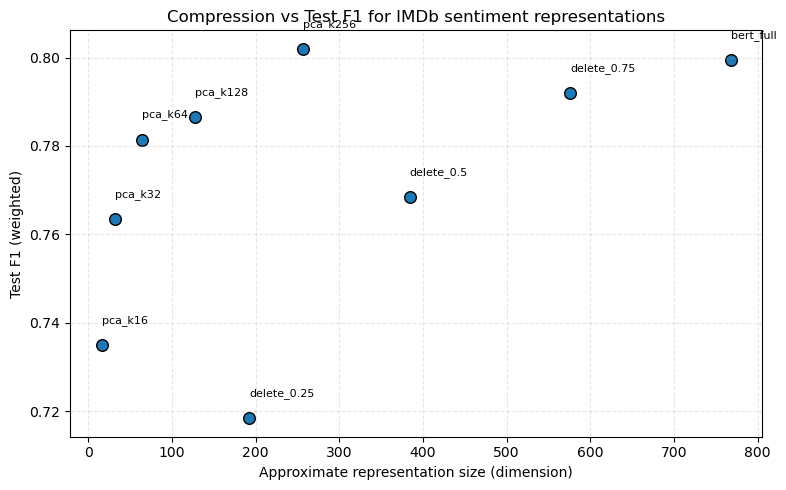

In [15]:
# Cell 15: Simple visualization of compression vs test F1 (with point labels)
# ---------------------------------------------------------------------------
# This cell:
# - Builds an approximate "representation size" for each method:
#     - Full BERT: original dimension (e.g., 768)
#     - PCA-k: k
#     - Deletion: keep_ratio * original_dimension (approximate)
# - Plots test F1 vs approximate size
# - Labels each point on the plot with the method name
# The colors are chosen to avoid yellow tones.

if "results_df" in globals():
    df_plot = results_df.copy()

    # Determine approximate size for each method (for x-axis)
    approx_sizes = []
    for method in df_plot["method"]:
        if method == "bert_full":
            # Use full BERT embedding dimension
            approx_sizes.append(train_emb_full.shape[1])
        elif method.startswith("pca_k"):
            k = int(method.split("pca_k")[1])
            approx_sizes.append(k)
        elif method.startswith("delete_"):
            r = float(method.split("delete_")[1])
            approx_sizes.append(r * train_emb_full.shape[1])
        else:
            approx_sizes.append(train_emb_full.shape[1])

    df_plot["approx_size"] = approx_sizes

    plt.figure(figsize=(8, 5))
    plt.scatter(
        df_plot["approx_size"],
        df_plot["test_f1"],
        s=70,
        edgecolor="black"
    )

    # Label each point with method name
    for _, row in df_plot.iterrows():
        x = row["approx_size"]
        y = row["test_f1"]
        plt.text(
            x,
            y + 0.005,
            row["method"],
            fontsize=8
        )

    plt.xlabel("Approximate representation size (dimension)")
    plt.ylabel("Test F1 (weighted)")
    plt.title("Compression vs Test F1 for IMDb sentiment representations")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df not found; please run the classifier cell first.")


In [16]:
# Cell 16: Build a unified results table for richer visualizations
# ----------------------------------------------------------------
# This cell merges:
#   - Classification metrics (results_df)
#   - Semantic preservation metrics (semantic_df)
# and adds derived columns such as:
#   - method_type: 'bert_full', 'pca', or 'deletion'
#   - pca_dim: PCA dimension for PCA methods
#   - keep_ratio: token keep ratio for deletion methods
#   - approx_size: approximate representation size (dimension)
# This unified DataFrame makes later plots much easier.

# Make safe copies of results from previous cells
plot_results_df = results_df.copy()
plot_semantic_df = semantic_df.copy()

method_types = []
pca_dims = []
keep_ratios = []
approx_sizes = []

original_dim = train_emb_full.shape[1]  # e.g., 768

for method in plot_results_df["method"]:
    if method == "bert_full":
        method_types.append("bert_full")
        pca_dims.append(None)
        keep_ratios.append(None)
        approx_sizes.append(original_dim)
    elif method.startswith("pca_k"):
        method_types.append("pca")
        k = int(method.split("pca_k")[1])
        pca_dims.append(k)
        keep_ratios.append(None)
        approx_sizes.append(k)
    elif method.startswith("delete_"):
        method_types.append("deletion")
        r = float(method.split("delete_")[1])
        pca_dims.append(None)
        keep_ratios.append(r)
        approx_sizes.append(r * original_dim)
    else:
        method_types.append("other")
        pca_dims.append(None)
        keep_ratios.append(None)
        approx_sizes.append(original_dim)

plot_results_df["method_type"] = method_types
plot_results_df["pca_dim"] = pca_dims
plot_results_df["keep_ratio"] = keep_ratios
plot_results_df["approx_size"] = approx_sizes

# Merge in semantic similarity scores using 'method' as the key
# Note: semantic_df has method names like 'pca_k64_reconstruct' and 'delete_0.5',
# while results_df has 'pca_k64' and 'delete_0.5'. We'll align PCA names below.
semantic_df_for_merge = plot_semantic_df.copy()

# Create a "base_method" column that matches results_df's method naming where possible
base_methods = []
for m in semantic_df_for_merge["method"]:
    if m.startswith("pca_k") and m.endswith("_reconstruct"):
        base_methods.append(m.replace("_reconstruct", ""))  # pca_k64_reconstruct -> pca_k64
    else:
        base_methods.append(m)
semantic_df_for_merge["base_method"] = base_methods

# Merge cosine similarity into results by matching base_method to method
plot_results_df = plot_results_df.merge(
    semantic_df_for_merge[["base_method", "mean_cosine_train"]],
    left_on="method",
    right_on="base_method",
    how="left"
)

# Clean up helper column
plot_results_df = plot_results_df.drop(columns=["base_method"])

display(plot_results_df)


,method,val_accuracy,val_f1,test_accuracy,test_f1,method_type,pca_dim,keep_ratio,approx_size,mean_cosine_train
0,bert_full,0.804000,0.803954,0.7995,0.799452,bert_full,NaN,NaN,768.0,NaN
1,pca_k16,0.758667,0.758649,0.7350,0.734894,pca,16.0,NaN,16.0,0.965409
2,pca_k32,0.771333,0.771216,0.7635,0.763490,pca,32.0,NaN,32.0,0.976180
3,pca_k64,0.785333,0.785253,0.7815,0.781454,pca,64.0,NaN,64.0,0.985273
4,pca_k128,0.778667,0.778560,0.7865,0.786455,pca,128.0,NaN,128.0,0.992681
5,pca_k256,0.794667,0.794567,0.8020,0.801967,pca,256.0,NaN,256.0,0.997438
6,delete_0.25,0.718000,0.717976,0.7185,0.718423,deletion,NaN,0.25,192.0,0.787540
7,delete_0.5,0.760000,0.759982,0.7685,0.768469,deletion,NaN,0.50,384.0,0.876463
8,delete_0.75,0.782667,0.782666,0.7920,0.791993,deletion,NaN,0.75,576.0,0.932577


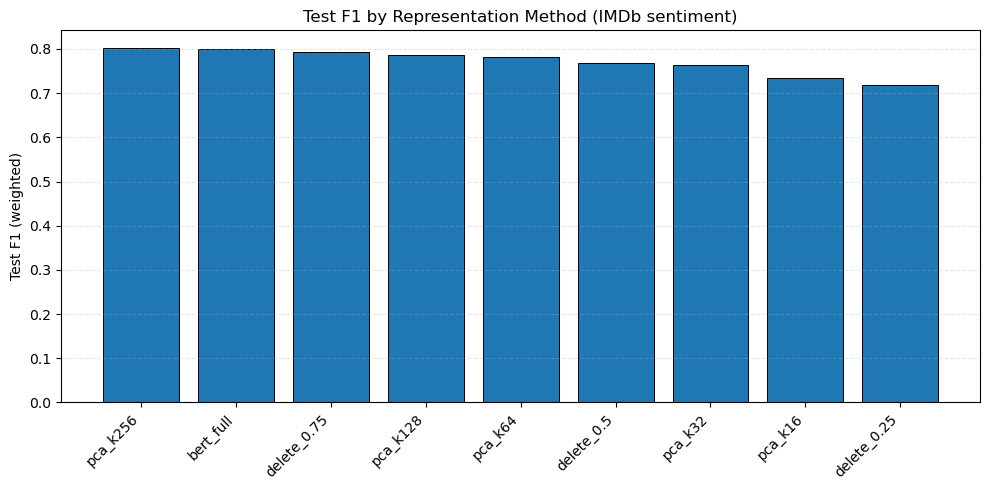

In [17]:
# Cell 17: Bar chart of test F1 by method (sorted)
# ------------------------------------------------
# This cell creates a bar chart to show:
#   - Which methods perform best on test F1
#   - How PCA and deletion methods compare to full BERT
# Bars are sorted from highest to lowest test F1 for clarity.

# Sort methods by test F1 descending
df_sorted = plot_results_df.sort_values("test_f1", ascending=False)

plt.figure(figsize=(10, 5))

# Use indices for x positions
x = np.arange(len(df_sorted))

# Use a non-yellow color for bars
bar_color = "tab:blue"

plt.bar(x, df_sorted["test_f1"], color=bar_color, edgecolor="black", linewidth=0.7)
plt.xticks(x, df_sorted["method"], rotation=45, ha="right")

plt.ylabel("Test F1 (weighted)")
plt.title("Test F1 by Representation Method (IMDb sentiment)")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


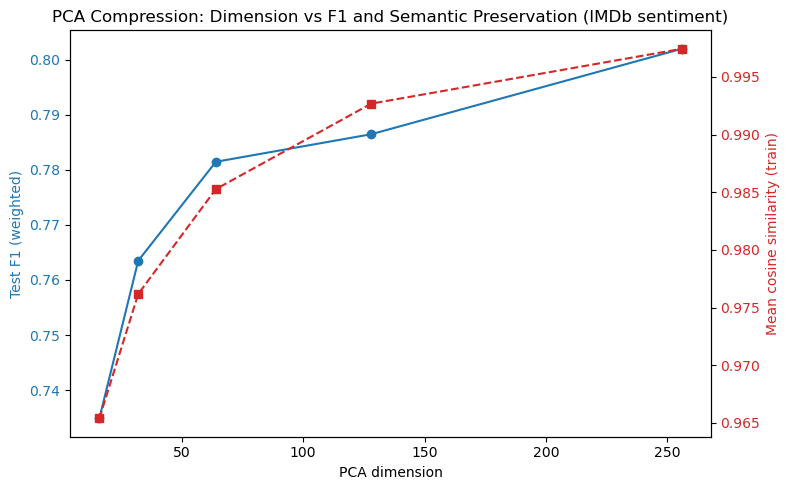

In [18]:
# Cell 18: PCA-only view — dimension vs F1 and cosine similarity
# --------------------------------------------------------------
# This cell focuses only on PCA-based methods and shows:
#   - Test F1 as a function of PCA dimension
#   - Mean cosine similarity (semantic preservation) as a function of dimension
# Both curves share the same x-axis (PCA dimension) and use two y-axes for clarity.

# Filter down to PCA methods only
pca_df = plot_results_df[plot_results_df["method_type"] == "pca"].copy()
pca_df = pca_df.sort_values("pca_dim")

plt.figure(figsize=(8, 5))

x = pca_df["pca_dim"].values

# Left y-axis: Test F1
ax1 = plt.gca()
color_f1 = "tab:blue"
ax1.plot(x, pca_df["test_f1"].values, marker="o", label="Test F1", color=color_f1)
ax1.set_xlabel("PCA dimension")
ax1.set_ylabel("Test F1 (weighted)", color=color_f1)
ax1.tick_params(axis="y", labelcolor=color_f1)

# Right y-axis: cosine similarity
ax2 = plt.gca().twinx()
color_cos = "tab:red"
ax2.plot(x, pca_df["mean_cosine_train"].values, marker="s", linestyle="--",
         label="Mean cosine similarity", color=color_cos)
ax2.set_ylabel("Mean cosine similarity (train)", color=color_cos)
ax2.tick_params(axis="y", labelcolor=color_cos)

plt.title("PCA Compression: Dimension vs F1 and Semantic Preservation (IMDb sentiment)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


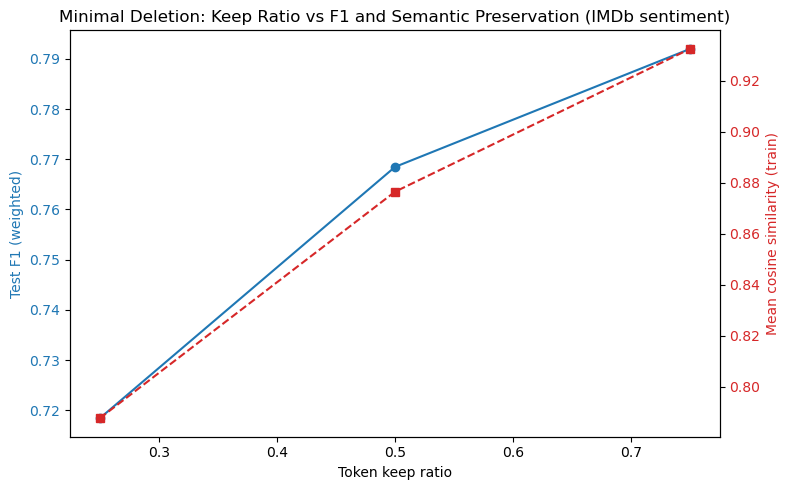

In [19]:
# Cell 19: Minimal deletion view — keep ratio vs F1 and cosine similarity
# -----------------------------------------------------------------------
# This cell focuses on minimal deletion methods and shows:
#   - Test F1 as a function of token keep_ratio
#   - Mean cosine similarity as a function of keep_ratio
# This highlights how aggressive token deletion affects sentiment performance and semantics.

# Filter down to deletion methods only
del_df = plot_results_df[plot_results_df["method_type"] == "deletion"].copy()
del_df = del_df.sort_values("keep_ratio")

plt.figure(figsize=(8, 5))

x = del_df["keep_ratio"].values

# Left y-axis: Test F1
ax1 = plt.gca()
color_f1 = "tab:blue"
ax1.plot(x, del_df["test_f1"].values, marker="o", label="Test F1", color=color_f1)
ax1.set_xlabel("Token keep ratio")
ax1.set_ylabel("Test F1 (weighted)", color=color_f1)
ax1.tick_params(axis="y", labelcolor=color_f1)

# Right y-axis: cosine similarity
ax2 = plt.gca().twinx()
color_cos = "tab:red"
ax2.plot(x, del_df["mean_cosine_train"].values, marker="s", linestyle="--",
         label="Mean cosine similarity", color=color_cos)
ax2.set_ylabel("Mean cosine similarity (train)", color=color_cos)
ax2.tick_params(axis="y", labelcolor=color_cos)

plt.title("Minimal Deletion: Keep Ratio vs F1 and Semantic Preservation (IMDb sentiment)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


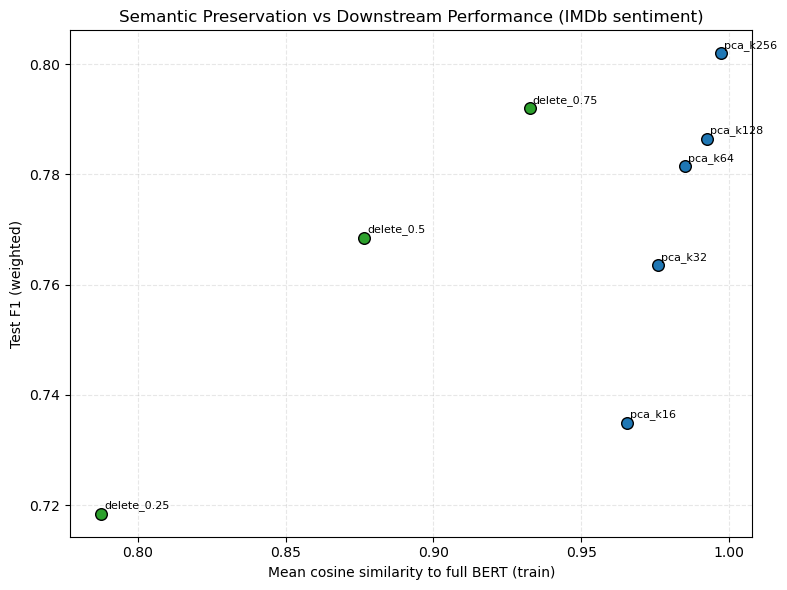

In [20]:
# Cell 20: Semantic preservation vs downstream performance (all methods)
# ----------------------------------------------------------------------
# This cell creates a scatter plot where:
#   - x-axis: mean cosine similarity (semantic preservation)
#   - y-axis: test F1 (classification performance)
# Each point is a method (full BERT, PCA variants, deletion variants).
# This directly illustrates the trade-off (or alignment) between representation quality
# and sentiment classification performance.

plt.figure(figsize=(8, 6))

# Simple color mapping by method type
color_map = {
    "bert_full": "tab:purple",
    "pca": "tab:blue",
    "deletion": "tab:green",
}

for _, row in plot_results_df.iterrows():
    method_type = row["method_type"]
    color = color_map.get(method_type, "tab:gray")
    plt.scatter(
        row["mean_cosine_train"],
        row["test_f1"],
        s=70,
        edgecolor="black",
        color=color
    )
    # Annotate each point with its method name
    plt.text(
        row["mean_cosine_train"] + 0.001,
        row["test_f1"] + 0.001,
        row["method"],
        fontsize=8
    )

plt.xlabel("Mean cosine similarity to full BERT (train)")
plt.ylabel("Test F1 (weighted)")
plt.title("Semantic Preservation vs Downstream Performance (IMDb sentiment)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
# Helper cell: identify top PCA and deletion methods & pretty names
# ----------------------------------------------------------------
# Run this BEFORE the F1 bar-chart cell.

# 1) Identify top PCA and deletion methods by test F1
pca_rows = plot_results_df[plot_results_df["method_type"] == "pca"] \
    .sort_values("test_f1", ascending=False)
del_rows = plot_results_df[plot_results_df["method_type"] == "deletion"] \
    .sort_values("test_f1", ascending=False)

top_pca_methods = list(pca_rows["method"].head(2))
top_del_methods = list(del_rows["method"].head(2))

# 2) Human-readable titles for methods
def pretty_method_name(m: str) -> str:
    if m == "bert_full":
        return "Full BERT Embeddings"
    elif m.startswith("pca_k"):
        k = int(m.split("pca_k")[1])
        return f"PCA ({k} dims)"
    elif m.startswith("delete_"):
        r = float(m.split("delete_")[1])
        return f"Deletion (keep_ratio={r})"
    else:
        return m


Computing confusion matrix for bert_full...
Computing confusion matrix for pca_k256...
Computing confusion matrix for delete_0.75...


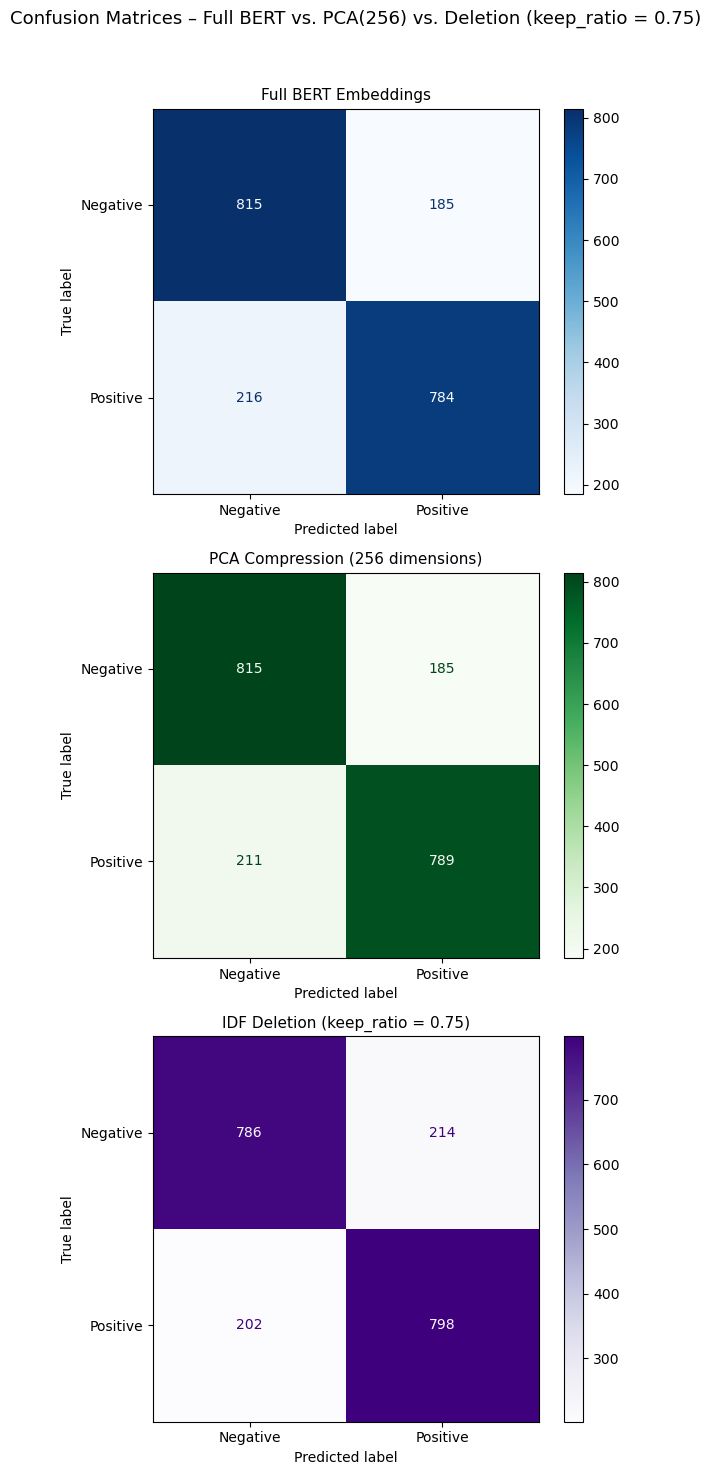

In [22]:
# Combined confusion matrices for Full BERT, PCA(256), and Deletion (keep_ratio=0.75)
# ----------------------------------------------------------------------
# Assumes the following are already defined in earlier cells:
#   - train_emb_full, test_emb_full
#   - compressed_train, compressed_test   (keys: k -> embedding arrays, e.g. 256)
#   - deleted_train_emb, deleted_test_emb (keys: keep_ratio -> embedding arrays, e.g. 0.75)
#   - y_train, y_test
#   - plot_results_df (not strictly required here, but used elsewhere)
#   - matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_classifier_and_predict(X_train, y_train, X_test):
    """
    Train a LogisticRegression classifier and return predicted labels on X_test.
    """
    clf = LogisticRegression(
        max_iter=5000,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def get_embeddings_for_method(method_name):
    """
    Map a method name to its (train_embeddings, test_embeddings) pair.

    Expected method names:
      - "bert_full"
      - "pca_k256"
      - "delete_0.75"
    """
    if method_name == "bert_full":
        return train_emb_full, test_emb_full
    elif method_name.startswith("pca_k"):
        k = int(method_name.split("pca_k")[1])
        return compressed_train[k], compressed_test[k]
    elif method_name.startswith("delete_"):
        r = float(method_name.split("delete_")[1])
        return deleted_train_emb[r], deleted_test_emb[r]
    else:
        raise ValueError(f"Unknown method: {method_name}")

# Methods and their labels/colormaps for the stacked figure
methods_to_plot = [
    ("bert_full",   "Full BERT Embeddings",                "Blues"),
    ("pca_k256",    "PCA Compression (256 dimensions)",    "Greens"),
    ("delete_0.75", "IDF Deletion (keep_ratio = 0.75)",    "Purples"),
]

class_names = ["Negative", "Positive"]

# Create a single figure with 3 subplots stacked vertically
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(6, 15)  # adjust height if needed
)

for ax, (method_name, title, cmap) in zip(axes, methods_to_plot):
    print(f"Computing confusion matrix for {method_name}...")
    Xtr, Xte = get_embeddings_for_method(method_name)
    y_pred = train_classifier_and_predict(Xtr, y_train, Xte)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=cmap, values_format="d", ax=ax)
    ax.set_title(title, fontsize=11)

plt.suptitle(
    "Confusion Matrices – Full BERT vs. PCA(256) vs. Deletion (keep_ratio = 0.75)",
    fontsize=13
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


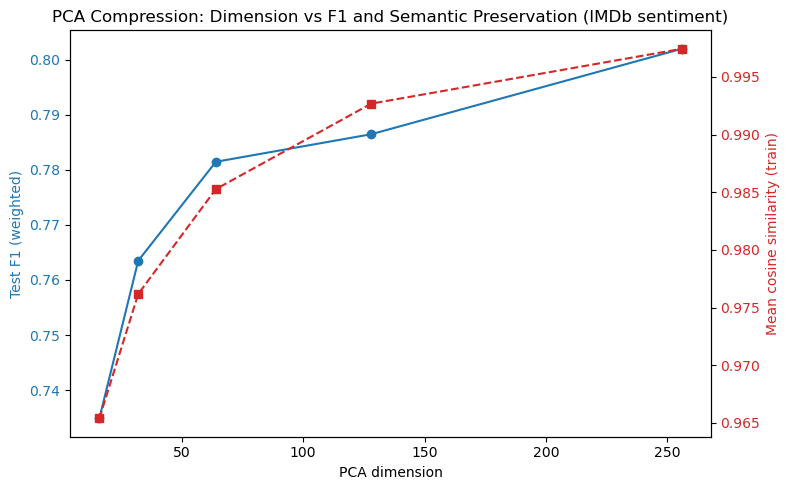

In [23]:
# Graph A: PCA – dimension vs Test F1 and cosine similarity
# ---------------------------------------------------------
# This cell builds a small PCA-only summary DataFrame and plots:
#   - Test F1 as a function of PCA dimension (left y-axis)
#   - Mean cosine similarity as a function of PCA dimension (right y-axis)

# Rebuild a minimal metadata frame for PCA methods
pca_rows = []
for _, row in results_df.iterrows():
    m = row["method"]
    if m.startswith("pca_k"):
        k = int(m.split("pca_k")[1])
        # Find corresponding cosine similarity
        cos_row = semantic_df[semantic_df["method"] == f"pca_k{k}_reconstruct"]
        cos_val = cos_row["mean_cosine_train"].values[0] if len(cos_row) > 0 else np.nan
        pca_rows.append({
            "pca_dim": k,
            "test_f1": row["test_f1"],
            "mean_cosine_train": cos_val,
        })

pca_summary = pd.DataFrame(pca_rows).sort_values("pca_dim")

plt.figure(figsize=(8, 5))
x = pca_summary["pca_dim"].values

# Left y-axis: Test F1
ax1 = plt.gca()
ax1.plot(x, pca_summary["test_f1"].values, marker="o", color="tab:blue")
ax1.set_xlabel("PCA dimension")
ax1.set_ylabel("Test F1 (weighted)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis: cosine similarity
ax2 = plt.gca().twinx()
ax2.plot(x, pca_summary["mean_cosine_train"].values, marker="s",
         linestyle="--", color="tab:red")
ax2.set_ylabel("Mean cosine similarity (train)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("PCA Compression: Dimension vs F1 and Semantic Preservation (IMDb sentiment)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


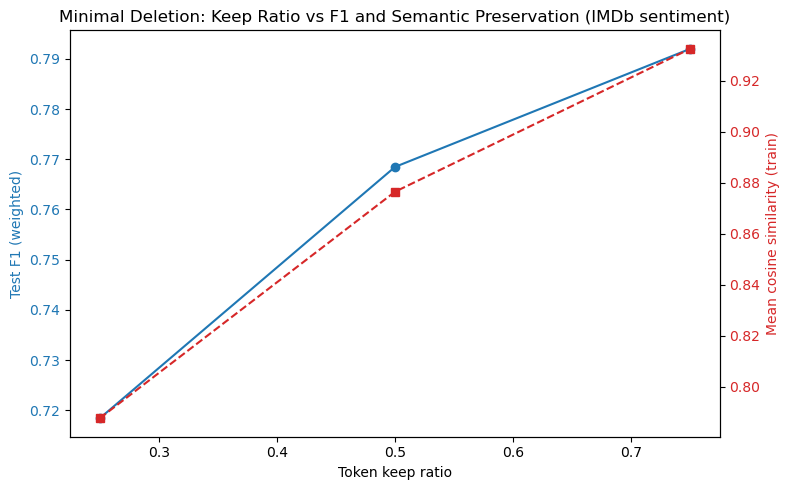

In [24]:
# Graph B: Minimal deletion – keep ratio vs Test F1 and cosine similarity
# -----------------------------------------------------------------------
# This cell builds a summary DataFrame for deletion methods and plots:
#   - Test F1 as a function of keep_ratio
#   - Mean cosine similarity as a function of keep_ratio

del_rows = []
for _, row in results_df.iterrows():
    m = row["method"]
    if m.startswith("delete_"):
        r = float(m.split("delete_")[1])
        cos_row = semantic_df[semantic_df["method"] == f"delete_{r}"]
        cos_val = cos_row["mean_cosine_train"].values[0] if len(cos_row) > 0 else np.nan
        del_rows.append({
            "keep_ratio": r,
            "test_f1": row["test_f1"],
            "mean_cosine_train": cos_val,
        })

del_summary = pd.DataFrame(del_rows).sort_values("keep_ratio")

plt.figure(figsize=(8, 5))
x = del_summary["keep_ratio"].values

# Left y-axis: Test F1
ax1 = plt.gca()
ax1.plot(x, del_summary["test_f1"].values, marker="o", color="tab:blue")
ax1.set_xlabel("Token keep ratio")
ax1.set_ylabel("Test F1 (weighted)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis: cosine similarity
ax2 = plt.gca().twinx()
ax2.plot(x, del_summary["mean_cosine_train"].values, marker="s",
         linestyle="--", color="tab:red")
ax2.set_ylabel("Mean cosine similarity (train)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Minimal Deletion: Keep Ratio vs F1 and Semantic Preservation (IMDb sentiment)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Methods for per-class F1 comparison: ['bert_full', 'pca_k256', 'pca_k128', 'delete_0.75', 'delete_0.5']
Computing per-class F1 for bert_full...
Computing per-class F1 for pca_k256...
Computing per-class F1 for pca_k128...
Computing per-class F1 for delete_0.75...
Computing per-class F1 for delete_0.5...


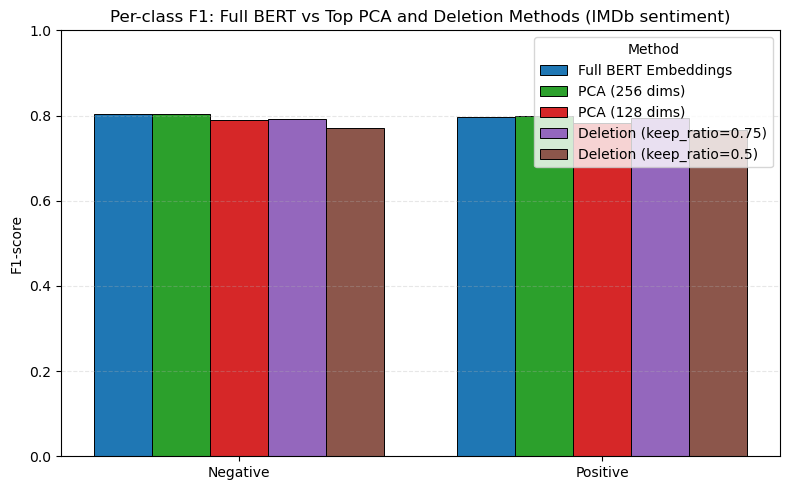

In [25]:
# Cell D: Per-class F1 for full BERT + top 2 PCA + top 2 deletion methods
# -----------------------------------------------------------------------
# This cell:
#   - Uses the same top PCA and deletion methods identified above
#   - Computes per-class F1 scores for each of the five methods
#   - Plots a grouped bar chart: one group per class, one bar per method

from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

def train_classifier_and_predict(X_train, y_train, X_test):
    """Train a LogisticRegression classifier and return predicted labels on X_test."""
    clf = LogisticRegression(
        max_iter=5000,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

# Reuse top methods from confusion-matrix cell
methods_for_f1 = ["bert_full"] + top_pca_methods + top_del_methods
pretty_names = [pretty_method_name(m) for m in methods_for_f1]

print("Methods for per-class F1 comparison:", methods_for_f1)

# Class labels and IMDb sentiment class names
class_indices = [str(i) for i in range(2)]  # "0", "1"
class_names = ["Negative", "Positive"]

# Compute per-class F1 for each method
f1_scores = []  # shape will be (num_methods, num_classes)

for method_name in methods_for_f1:
    print(f"Computing per-class F1 for {method_name}...")
    Xtr, Xte = get_embeddings_for_method(method_name)
    y_pred = train_classifier_and_predict(Xtr, y_train, Xte)

    report = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    # Extract per-class F1 for classes 0,1
    method_f1 = [report[idx]["f1-score"] for idx in class_indices]
    f1_scores.append(method_f1)

f1_scores = np.array(f1_scores)  # shape: (num_methods, num_classes)

# Plot grouped bar chart
num_methods, num_classes = f1_scores.shape
x = np.arange(num_classes)

# Width of each bar; total group width ~0.8
total_width = 0.8
bar_width = total_width / num_methods

# Choose distinct, non-yellow colors
colors = ["tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(8, 5))

for i in range(num_methods):
    plt.bar(
        x + i * bar_width - total_width / 2 + bar_width / 2,
        f1_scores[i],
        width=bar_width,
        label=pretty_names[i],
        color=colors[i % len(colors)],
        edgecolor="black",
        linewidth=0.7
    )

plt.xticks(x, class_names)
plt.ylabel("F1-score")
plt.ylim(0, 1.0)
plt.title("Per-class F1: Full BERT vs Top PCA and Deletion Methods (IMDb sentiment)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Method")
plt.tight_layout()
plt.show()


# Beginning of code for project GUI

In [26]:
# ==== GUI SETUP: imports, classifier, helpers (no embedding projection) ====

import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

import gradio as gr

# We assume the following already exist from earlier cells:
# - tokenizer
# - model
# - get_bert_embeddings(text_list)
# - compress_text_by_deletion(text, tokenizer, idf_scores, keep_ratio, max_len)
# - idf_scores
# - pca_models: dict[int -> PCA]
# - train_emb_full, val_emb_full, test_emb_full
# - X_train, X_val, X_test, y_train, y_val, y_test
# - MAX_LEN

# ---- Train a classifier on full embeddings (if not already trained) ----
try:
    clf_full
    print("Using existing clf_full classifier.")
except NameError:
    print("Training full-embedding Logistic Regression classifier for GUI...")
    clf_full = LogisticRegression(max_iter=5000, n_jobs=-1)
    clf_full.fit(train_emb_full, y_train)
    print("Finished training clf_full.")

# ---- Separate max token length for deletion (to avoid cutting off reviews) ----
# BERT still uses MAX_LEN for embeddings, but for the *displayed* compressed text
# we allow a larger number of tokens so the review isn't truncated as aggressively.
DELETION_MAX_TOKENS = 512


# ---- Helper: embed a single text ----
def embed_text_single(text: str) -> np.ndarray:
    """
    Compute a single BERT embedding for a text using get_bert_embeddings().
    Returns a 1D numpy array of shape (hidden_dim,).
    """
    if not text.strip():
        # Empty text -> zero vector placeholder
        return np.zeros(train_emb_full.shape[1], dtype=np.float32)
    emb = get_bert_embeddings([text])  # (1, D)
    return emb[0]


# ---- Helper: IDF-based deletion for GUI ----
def delete_tokens_for_gui(text: str, keep_ratio: float, max_len: int = DELETION_MAX_TOKENS) -> str:
    """
    Compress a text by deleting low-IDF tokens using the global tokenizer and idf_scores.

    We use a larger max_len for deletion than for BERT (DELETION_MAX_TOKENS) so the
    *visible* compressed review is not prematurely cut off.
    """
    return compress_text_by_deletion(
        text,
        tokenizer=tokenizer,
        idf_scores=idf_scores,
        keep_ratio=keep_ratio,
        max_len=max_len,
    )


# ---- Helper: classify with full BERT embeddings ----
def classify_with_full_bert(emb: np.ndarray) -> dict:
    """
    Run the full-embedding classifier (clf_full) on a single embedding vector.

    Returns:
        {
          "probs": np.array([p_neg, p_pos]),
          "label": "Negative" or "Positive"
        }
    """
    X = emb.reshape(1, -1)
    probs = clf_full.predict_proba(X)[0]  # (2,)
    label_idx = int(np.argmax(probs))
    label = "Negative" if label_idx == 0 else "Positive"
    return {"probs": probs, "label": label}


# ---- Helper: apply PCA compression + reconstruction ----
def apply_pca_to_embedding(emb: np.ndarray, k: int) -> np.ndarray:
    """
    Compress an embedding with the PCA model of dimension k, then
    inverse-transform back to full dimension.

    Returns:
        Reconstructed full-dim embedding (same size as train_emb_full).
    """
    if k not in pca_models:
        raise ValueError(f"No PCA model found for k={k}. Available keys: {list(pca_models.keys())}")

    pca_k = pca_models[k]
    compressed = pca_k.transform(emb.reshape(1, -1))        # (1, k)
    reconstructed = pca_k.inverse_transform(compressed)      # (1, D)
    return reconstructed[0]


# ---- Helper: similarity metrics ----
def compute_similarity(emb_orig: np.ndarray, emb_alt: np.ndarray) -> dict:
    """
    Compute cosine similarity and L2 distance between two embeddings.
    """
    a = emb_orig.reshape(1, -1)
    b = emb_alt.reshape(1, -1)

    cos = cosine_similarity(a, b)[0, 0]
    l2 = np.linalg.norm(a - b)

    return {"cosine": float(cos), "l2": float(l2)}


# ---- Helper: get a random review from a split ----
def gui_random_review(split: str = "test") -> str:
    """
    Return a random review string from one of the dataset splits: 'train', 'val', or 'test'.
    Defaults to test split.
    """
    if split == "train":
        pool = X_train
    elif split == "val":
        pool = X_val
    else:
        pool = X_test

    if pool is None or len(pool) == 0:
        return ""
    return random.choice(pool)


Training full-embedding Logistic Regression classifier for GUI...
Finished training clf_full.


In [27]:
# ==== TOKEN-LEVEL DIFF VISUALIZATION FOR DELETION MODE ====

def token_diff_html(original_text: str, compressed_text: str) -> str:
    """
    Produce an HTML visualization of token-level differences between the
    original text and its IDF-based compressed version.

    - Original tokens that remain are shown in dark text.
    - Tokens that were removed are shown in red with strikethrough.
    - The compressed text is shown below.

    Note: Because of BERT wordpieces (##), visualization is at token level,
    not necessarily whole words, but it still conveys the deletion pattern.
    """
    # Tokenize without special tokens; use DELETION_MAX_TOKENS for fairness with deletion
    enc_orig = tokenizer(
        original_text,
        add_special_tokens=False,
        truncation=True,
        max_length=DELETION_MAX_TOKENS,
        return_tensors=None,
    )
    enc_comp = tokenizer(
        compressed_text,
        add_special_tokens=False,
        truncation=True,
        max_length=DELETION_MAX_TOKENS,
        return_tensors=None,
    )

    orig_ids = enc_orig["input_ids"]
    comp_ids = enc_comp["input_ids"]

    # Multiset of kept token IDs
    kept_counts = {}
    for tid in comp_ids:
        kept_counts[tid] = kept_counts.get(tid, 0) + 1

    orig_tokens = tokenizer.convert_ids_to_tokens(orig_ids)

    html_tokens = []
    for tid, tok in zip(orig_ids, orig_tokens):
        count = kept_counts.get(tid, 0)
        if count > 0:
            # Token kept
            kept_counts[tid] = count - 1
            html_tokens.append(f"<span style='color:#222222;'>{tok}</span>")
        else:
            # Token deleted
            html_tokens.append(
                "<span style='color:#b22222;text-decoration:line-through;'>"
                f"{tok}</span>"
            )

    joined = " ".join(html_tokens)
    wrapped = (
        "<div><strong>Token-level diff (original):</strong><br>"
        f"{joined}</div>"
        "<div style='margin-top:0.5em;'><strong>Compressed text:</strong><br>"
        f"{compressed_text}</div>"
    )
    return wrapped


In [28]:
# ==== PLOTTING FUNCTIONS FOR GUI OUTPUT ====

def make_probability_plot(orig_probs: np.ndarray, alt_probs: np.ndarray):
    """
    Create a matplotlib figure comparing original vs altered sentiment probabilities.

    orig_probs, alt_probs: arrays of shape (2,) in order [p_neg, p_pos].
    """
    labels = ["Negative", "Positive"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(5, 4))

    # Original in blue, altered in red (no yellow)
    ax.bar(
        x - width / 2,
        orig_probs,
        width,
        label="Original",
        color="tab:blue",
        edgecolor="black",
    )
    ax.bar(
        x + width / 2,
        alt_probs,
        width,
        label="Altered",
        color="tab:red",
        edgecolor="black",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Probability")
    ax.set_title("Sentiment probabilities: original vs altered")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend()

    fig.tight_layout()
    return fig


def make_space_plot(
    orig_text_bytes: int,
    orig_emb_bytes: int,
    alt_text_bytes: int,
    alt_emb_bytes: int,
):
    """
    Create a stacked bar chart comparing approximate disk space (bytes)
    before vs after the edit.

    For each review we show:
      - Text bytes (UTF-8 length of the review string)
      - Embedding bytes (float32 values used to represent the review)

    This works for both:
      - Minimal Deletion: text bytes change, embedding bytes stay the same.
      - PCA Compression: text bytes stay the same, embedding bytes shrink.
    """
    labels = ["Original", "Altered"]
    text_sizes = [orig_text_bytes, alt_text_bytes]
    emb_sizes = [orig_emb_bytes, alt_emb_bytes]
    x = np.arange(len(labels))
    width = 0.6

    fig, ax = plt.subplots(figsize=(5, 4))

    # Stacked bars: bottom = text, top = embedding
    ax.bar(
        x,
        text_sizes,
        width,
        label="Text bytes",
        color="tab:blue",
        edgecolor="black",
    )
    ax.bar(
        x,
        emb_sizes,
        width,
        bottom=text_sizes,
        label="Embedding bytes",
        color="tab:green",
        edgecolor="black",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Approx. disk space (bytes)")
    ax.set_title("Approximate review size before vs after edit")

    # Annotate totals on top
    totals = [t + e for t, e in zip(text_sizes, emb_sizes)]
    max_total = max(totals) if totals else 1
    offset = max(1, 0.02 * max_total)

    for i, total in enumerate(totals):
        ax.text(
            i,
            total + offset,
            str(total),
            ha="center",
            va="bottom",
            fontsize=9,
        )

    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig


In [29]:
# ==== MAIN GRADIO CALLBACK (disk-space plot instead of embedding projection) ====

def gui_compare(
    original_text: str,
    edited_text: str,
    edit_mode: str,
    keep_ratio: float,
    pca_dim: int,
):
    """
    Main Gradio callback:

      1. Takes original text and optional manually edited version.
      2. Applies preset transformation if requested (Minimal Deletion or PCA).
      3. Computes embeddings and full-embedding classifier predictions.
      4. Computes similarity metrics and builds:
         - probability plot
         - approximate disk space stacked bar chart
         - token-diff HTML (for deletion)

    Returns:
      summary_html, prob_fig, space_fig, diff_html
    """

    # --- 0. Basic validation ---
    if not original_text.strip():
        return (
            "<p style='color:red;'>Please enter an original review or use the random button.</p>",
            None,
            None,
            "",
        )

    # If user left edited box empty, treat it as original
    base_text = edited_text.strip() if edited_text.strip() else original_text

    # --- 1. Determine altered text based on edit_mode ---
    if edit_mode == "None":
        altered_text = base_text

    elif edit_mode == "Minimal Deletion":
        # Use larger DELETION_MAX_TOKENS so compressed text isn't overly truncated
        altered_text = delete_tokens_for_gui(base_text, keep_ratio=keep_ratio)

    elif edit_mode == "PCA Compression":
        # PCA operates in embedding space; text itself is unchanged
        altered_text = base_text

    else:
        altered_text = base_text

    # --- 2. Compute embeddings for original and altered text ---
    emb_orig_full = embed_text_single(original_text)
    emb_alt_full = embed_text_single(altered_text)

    # --- 3. Determine which embedding representation to classify for altered text ---
    if edit_mode == "PCA Compression":
        try:
            k_int = int(pca_dim)
            emb_alt_for_clf = apply_pca_to_embedding(emb_alt_full, k=k_int)
            clf_tag = f"PCA-compressed (k={k_int})"
            emb_dim_alt = k_int  # compressed embedding stored as k floats
        except Exception as e:
            emb_alt_for_clf = emb_alt_full
            clf_tag = f"PCA-compressed (k={pca_dim}) – fallback to full embedding ({e})"
            emb_dim_alt = emb_orig_full.shape[0]
    else:
        emb_alt_for_clf = emb_alt_full
        clf_tag = "Full BERT (no PCA)"
        emb_dim_alt = emb_orig_full.shape[0]

    # --- 4. Classify original and altered embeddings ---
    orig_pred = classify_with_full_bert(emb_orig_full)
    alt_pred = classify_with_full_bert(emb_alt_for_clf)

    # --- 5. Similarity metrics (numeric only) ---
    sim = compute_similarity(emb_orig_full, emb_alt_for_clf)

    # --- 6. Approximate disk space (bytes) for text + embedding ---

    # Text bytes (UTF-8 encoded length)
    orig_text_bytes = len(original_text.encode("utf-8"))
    alt_text_bytes = len(altered_text.encode("utf-8"))

    # Embedding bytes: float32 = 4 bytes
    emb_dim_full = emb_orig_full.shape[0]
    orig_emb_bytes = 4 * emb_dim_full
    alt_emb_bytes = 4 * emb_dim_alt

    space_fig = make_space_plot(
        orig_text_bytes,
        orig_emb_bytes,
        alt_text_bytes,
        alt_emb_bytes,
    )

    orig_total_bytes = orig_text_bytes + orig_emb_bytes
    alt_total_bytes = alt_text_bytes + alt_emb_bytes
    if orig_total_bytes > 0:
        total_reduction_pct = 100.0 * (orig_total_bytes - alt_total_bytes) / orig_total_bytes
    else:
        total_reduction_pct = 0.0

    # --- 7. Probability plot ---
    prob_fig = make_probability_plot(orig_pred["probs"], alt_pred["probs"])

    # --- 8. Token diff HTML (only for minimal deletion mode) ---
    if edit_mode == "Minimal Deletion":
        diff_html = token_diff_html(base_text, altered_text)
    else:
        diff_html = (
            "<div><em>Token-level diff visualization is only available in "
            "<strong>Minimal Deletion</strong> mode.</em></div>"
        )

    # --- 9. Summary HTML of predictions, size, and similarity ---
    orig_p_neg, orig_p_pos = orig_pred["probs"]
    alt_p_neg, alt_p_pos = alt_pred["probs"]

    summary_html = f"""
    <div>
      <h3>Summary</h3>
      <p><strong>Original text:</strong> {original_text}</p>
      <p><strong>Altered text:</strong> {altered_text}</p>

      <h4>Predictions</h4>
      <ul>
        <li><strong>Original</strong> (Full BERT): {orig_pred["label"]}
            &mdash; P(Neg) = {orig_p_neg:.3f}, P(Pos) = {orig_p_pos:.3f}</li>
        <li><strong>Altered</strong> ({clf_tag}): {alt_pred["label"]}
            &mdash; P(Neg) = {alt_p_neg:.3f}, P(Pos) = {alt_p_pos:.3f}</li>
      </ul>

      <h4>Approximate disk space</h4>
      <ul>
        <li>Original: {orig_total_bytes} bytes
            (text = {orig_text_bytes}, embedding = {orig_emb_bytes})</li>
        <li>Altered: {alt_total_bytes} bytes
            (text = {alt_text_bytes}, embedding = {alt_emb_bytes})</li>
        <li>Total change: {total_reduction_pct:+.1f}%</li>
      </ul>

      <h4>Embedding similarity (numeric only)</h4>
      <ul>
        <li>Cosine similarity (orig vs altered): {sim["cosine"]:.4f}</li>
        <li>L2 distance &Vert;orig - alt&Vert;: {sim["l2"]:.4f}</li>
      </ul>
    </div>
    """

    return summary_html, prob_fig, space_fig, diff_html


In [33]:
# ==== BUILD AND LAUNCH THE GRADIO APP (with disk-space plot) ====

available_pca_dims = sorted(pca_models.keys())

with gr.Blocks(
    title="Sentiment Compression Playground",
    fill_height=True,
    fill_width=True,
) as demo:
    gr.Markdown("## Sentiment Compression Playground (IMDb + BERT)")
    gr.Markdown(
        "Interactively explore how IDF-based token deletion and PCA compression "
        "affect BERT-based sentiment predictions on movie reviews."
    )

    with gr.Row():
        # Left column: inputs and controls
        with gr.Column():
            original_text = gr.Textbox(
                label="Original review",
                placeholder="Type or paste a movie review here, or use the random button...",
                lines=6,
            )

            edited_text = gr.Textbox(
                label="Manually edited review (optional)",
                placeholder=(
                    "You can edit the review here before applying presets. "
                    "If left blank, the original review is used."
                ),
                lines=6,
            )

            # Button to sample a random review from the dataset
            random_btn = gr.Button("Use random dataset review")

            edit_mode = gr.Radio(
                label="Preset edit",
                choices=["None", "Minimal Deletion", "PCA Compression"],
                value="None",
            )

            keep_ratio = gr.Slider(
                label="Token keep ratio (Minimal Deletion)",
                minimum=0.1,
                maximum=1.0,
                step=0.05,
                value=0.5,
            )

            # PCA dimension: restrict to exactly the trained PCA dimensions via Dropdown
            pca_dim = gr.Dropdown(
                label="PCA dimension (PCA Compression)",
                choices=available_pca_dims,
                value=available_pca_dims[0],
                type="value",
            )

            run_btn = gr.Button("Apply edit & compare", variant="primary")

        # Right column: outputs
        with gr.Column():
            summary_out = gr.HTML(label="Summary")
            prob_plot_out = gr.Plot(label="Sentiment probabilities")
            space_plot_out = gr.Plot(label="Approximate disk space before vs after")
            token_diff_out = gr.HTML(label="Token-level diff")

    # Random-review button: fill original_text and clear edited_text
    def _random_and_clear():
        text = gui_random_review(split="test")
        return text, ""

    random_btn.click(
        fn=_random_and_clear,
        inputs=None,
        outputs=[original_text, edited_text],
    )

    # Main compare button
    run_btn.click(
        fn=gui_compare,
        inputs=[original_text, edited_text, edit_mode, keep_ratio, pca_dim],
        outputs=[summary_out, prob_plot_out, space_plot_out, token_diff_out],
    )

# Increase inline height in Colab so the app is more visible in the output box
demo.launch(height=1000, share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://dea48976924ed77671.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Extra figures for report

In [31]:
# Figure 5: Token-level diff visualization for a sample review
from IPython.display import HTML, display

sample_text = X_test[1]
keep_ratio_example = 0.5
compressed_text = delete_tokens_for_gui(sample_text, keep_ratio=keep_ratio_example)

html = token_diff_html(sample_text, compressed_text)
display(HTML(html))


Text(0.5, 1.02, 'Figure 8(b): Disk space – Minimal Deletion (keep_ratio=0.5)')

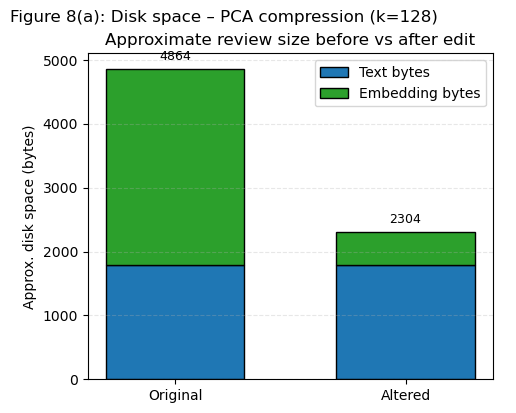

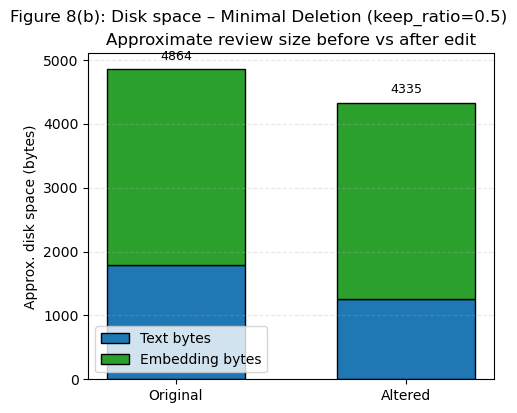

In [32]:
# Figure 8: Approximate disk space for PCA vs Minimal Deletion
sample_text = X_test[0]

# Baseline embedding
emb_full = embed_text_single(sample_text)
orig_dim = emb_full.shape[0]
orig_text_bytes = len(sample_text.encode("utf-8"))
orig_emb_bytes = 4 * orig_dim

# (a) PCA compression example
k_example = 128
pca_emb_bytes = 4 * k_example
fig_pca = make_space_plot(
    orig_text_bytes,
    orig_emb_bytes,
    orig_text_bytes,   # text unchanged
    pca_emb_bytes
)
fig_pca.suptitle("Figure 8(a): Disk space – PCA compression (k=128)             ", y=1.02)

# (b) Minimal deletion example
keep_ratio_example = 0.5
compressed_text = delete_tokens_for_gui(sample_text, keep_ratio=keep_ratio_example)
compressed_text_bytes = len(compressed_text.encode("utf-8"))
fig_del = make_space_plot(
    orig_text_bytes,
    orig_emb_bytes,
    compressed_text_bytes,
    orig_emb_bytes      # embedding dimension unchanged
)
fig_del.suptitle("Figure 8(b): Disk space – Minimal Deletion (keep_ratio=0.5)", y=1.02)
